# Schema spettrometro (notebook Python)

Sistema da risolvere:

$\left\{ \begin{align*}   &n_1 \sin\left( {\alpha \over 2} \right)
  = \sin\left( {{\theta_1-\theta_0+\alpha} \over 2} \right)\\
   &n_2 \sin\left( {\alpha \over 2} \right)
  = \sin\left( {{\theta_2-\theta_0+\alpha} \over 2} \right)\\
  &n_1 = A + {B\over \lambda^2_1}\\
  &n_2 = A + {B\over \lambda^2_2}\\
  \end{align*}
 \right.$

Import dei moduli rilevanti

In [1]:
import math as m
import time
from ROOT import*

Welcome to JupyROOT 6.14/04


/usr/local/root/lib/ROOT.py:577: UserWarning: "from ROOT import *" is not supported under IPython
  warnings.warn( '"from ROOT import *" is not supported under IPython' )


Parametri dello spettrometro

In [2]:
alpha   = m.pi/3
lambda1 = 579.1
lambda2 = 404.7
th0     = 1.5701
th1     = 2.6958
th2     = 2.7904
delta_th     = 0.0005
eth=delta_th/m.sqrt(3)


Funzione che, dati gli angoli $\theta_0$, $\theta_1$ e $\theta_2$, calcola A e B

In [3]:
def computeAB(th0,th1,th2):
    B = (((lambda1*lambda2)**2)/((lambda1**2-lambda2**2)*m.sin(alpha/2)))*(m.sin((th2-th0+alpha)/2)-m.sin((th1-th0+alpha)/2))
    A = m.sin((th1-th0+alpha)/2)/(m.sin(alpha/2))-B/(lambda1**2)
    return A,B

def computeN1N2(A,B):
    return A+B/(lambda1**2),A+B/(lambda2**2)

def computeDT1DT2(A,B):
    dt1=2*m.asin((A+B/lambda1**2)*m.sin(alpha/2))-alpha
    dt2=2*m.asin((A+B/lambda2**2)*m.sin(alpha/2))-alpha
    return dt1,dt2
  

Programma principale

In [4]:
rnd=TRandom3()
rnd.SetSeed(int(time.time()))

# Assumendo errore gaussiano (eth/sqrt(3)) 
# a) calcolo dell'errore su A e su B tramite variazione delle funzione
# b) calcolo delle distribuzioni di A e B
#    dell'errore su A, B e della loro correlazione

# Ripetere punto b) nel caso in cui invece si assuma distribuzione uniforme con larghezza +/-eth

'''
CALCOLO CON VARIAZIONE FUNZIONE
'''
def errABp(th0,th1,th2,eth):

    fda,fdb=computeAB(th0,th1,th2)
    fs0a,fs0b=computeAB(th0+eth,th1,th2)
    
    fs1a,fs1b=computeAB(th0,th1+eth,th2)
    
    fs2a,fs2b=computeAB(th0,th1,th2+eth)
    
    der0a=(fs0a-fda)
    der1a=(fs1a-fda)
    der2a=(fs2a-fda)
    
    der0b=(fs0b-fdb)
    der1b=(fs1b-fdb)
    der2b=(fs2b-fdb)
    
    eA = m.sqrt(der0a**2 + der1a**2+ der2a**2)
    eB = m.sqrt(der0b**2 + der1b**2+ der2b**2)

    return eA,eB

def errABm(th0,th1,th2,eth):

    fda,fdb=computeAB(th0,th1,th2)
    fs0a,fs0b=computeAB(th0-eth,th1,th2)
    
    fs1a,fs1b=computeAB(th0,th1-eth,th2)
    
    fs2a,fs2b=computeAB(th0,th1,th2-eth)
    
    der0a=(fs0a-fda)
    der1a=(fs1a-fda)
    der2a=(fs2a-fda)
    
    der0b=(fs0b-fdb)
    der1b=(fs1b-fdb)
    der2b=(fs2b-fdb)
    
    eA = m.sqrt(der0a**2 + der1a**2 + der2a**2)
    eB = m.sqrt(der0b*der0b + der1b*der1b + der2b*der2b)

    return eA,eB

AB=computeAB(th0,th1,th2)
print('AB',AB)

eABp=errABp(th0,th1,th2,eth)
print('errAB+',eABp)

eABm=errABm(th0,th1,th2,eth)
print('errAB-',eABm)

('AB', (1.7298151476003434, 13462.13725684549))
('errAB+', (0.00032241944739872875, 58.27445369539045))
('errAB-', (0.00032247487969408613, 58.291298034996736))


In [5]:
'''
CALCOLO CON METODO MONTE CARLO (DISTRIBUZIONE GAUSSIANA)
'''

N=10000
sig=eth

hA=TH1D("hA","",100,0,0)
hB=TH1D("hB","",100,0,0)
H=TH2D("H","",100,0,0,100,0,0)

for i in range(0,N):
    theta0=rnd.Gaus(th0,sig)
    theta1=rnd.Gaus(th1,sig)
    theta2=rnd.Gaus(th2,sig)
    
    a,b=computeAB(theta0,theta1,theta2)
    
    hA.Fill(a)
    hB.Fill(b)
    H.Fill(a,b)


c1=TCanvas("c1","",600,600)
c2=TCanvas("c2","",600,600)
c3=TCanvas("c3","",600,600)

(1.7298120832328192, 0.0003246071854802663)


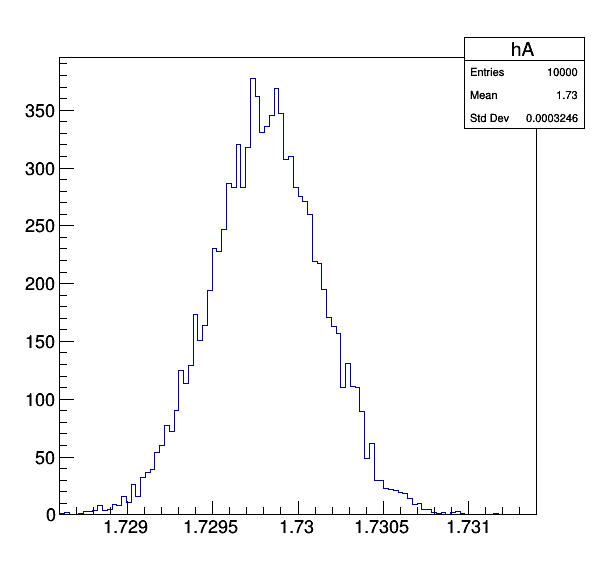

In [6]:
c1.Draw()
c1.cd()
hA.Draw()
print(hA.GetMean(),hA.GetStdDev())
meanA=hA.GetMean()
sigA=hA.GetStdDev()

(13462.347984625065, 58.7034793982166)


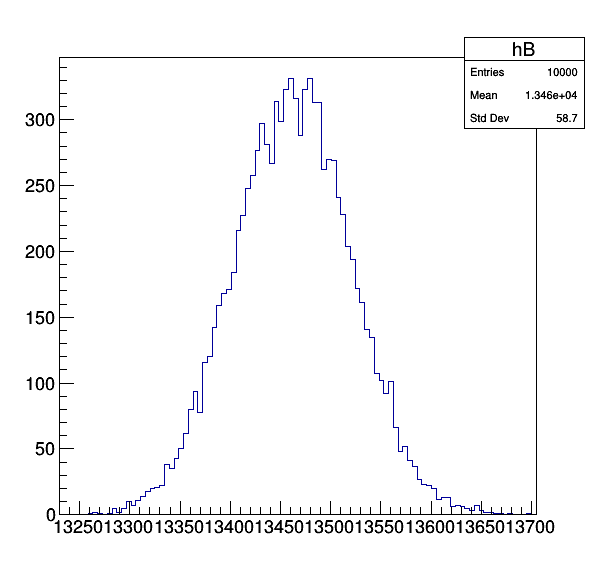

In [7]:
c2.Draw()
c2.cd()
hB.Draw()
print(hB.GetMean(),hB.GetStdDev())
meanB=hB.GetMean()
sigB=hB.GetStdDev()

-0.876313949015


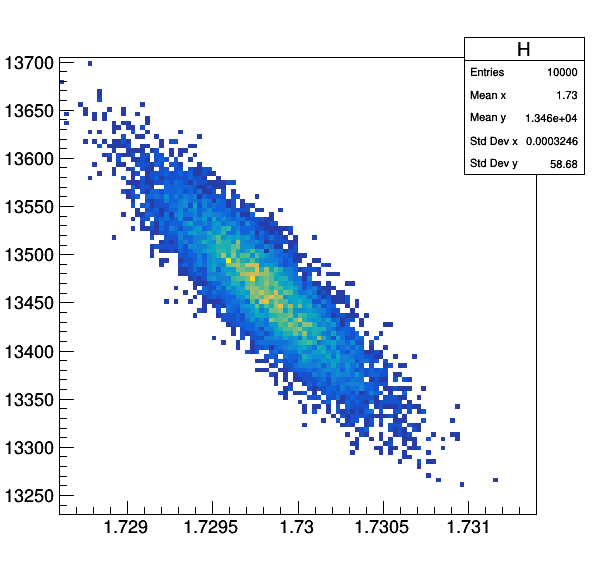

In [8]:
c3.Draw()
c3.cd()
H.Draw("COL")
print(H.GetCorrelationFactor())

In [9]:
'''
CALCOLO CON METODO MONTECARLO (DISTRIBUZIONE UNIFORME)
'''

N=10000
sig=eth

hA=TH1D("hA","",100,0,0)
hB=TH1D("hB","",100,0,0)
H=TH2D("H","",100,0,0,100,0,0)

for i in range(0,N):
    theta0=2*delta_th*rnd.Rndm()+th0-delta_th
    theta1=2*delta_th*rnd.Rndm()+th1-delta_th
    theta2=2*delta_th*rnd.Rndm()+th2-delta_th
    
    a,b=computeAB(theta0,theta1,theta2)
    
    hA.Fill(a)
    hB.Fill(b)
    H.Fill(a,b)

c1=TCanvas("c1","",600,600)
c2=TCanvas("c2","",600,600)
c3=TCanvas("c3","",600,600)


Warning in <TROOT::Append>: Replacing existing TH1: hA (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hB (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: H (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c3


(1.7298108379827979, 0.0003217971501586376)


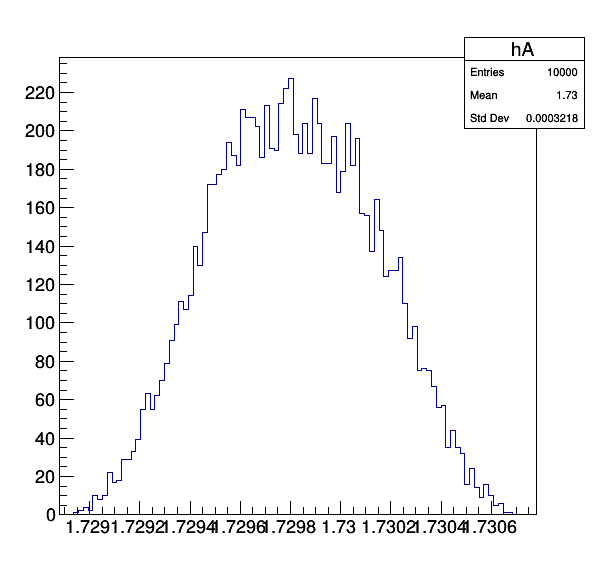

In [10]:
c1.Draw()
c1.cd()
hA.Draw()
print(hA.GetMean(),hA.GetStdDev())

(13462.751658974907, 58.1547585477528)


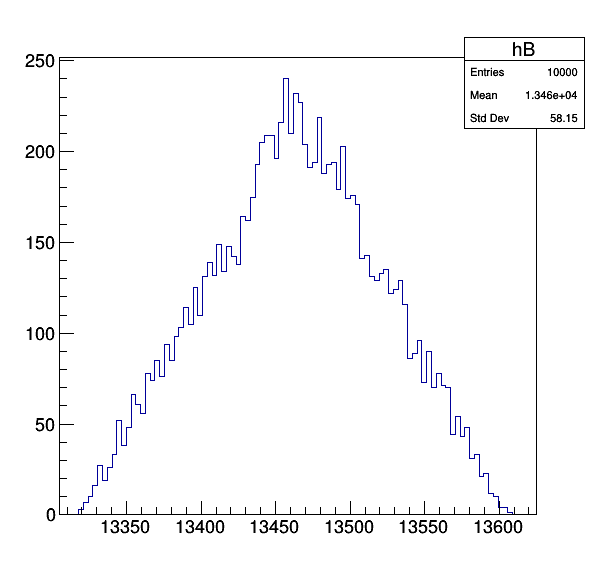

In [11]:
c2.Draw()
c2.cd()
hB.Draw()
print(hB.GetMean(),hB.GetStdDev())

-0.873472877477


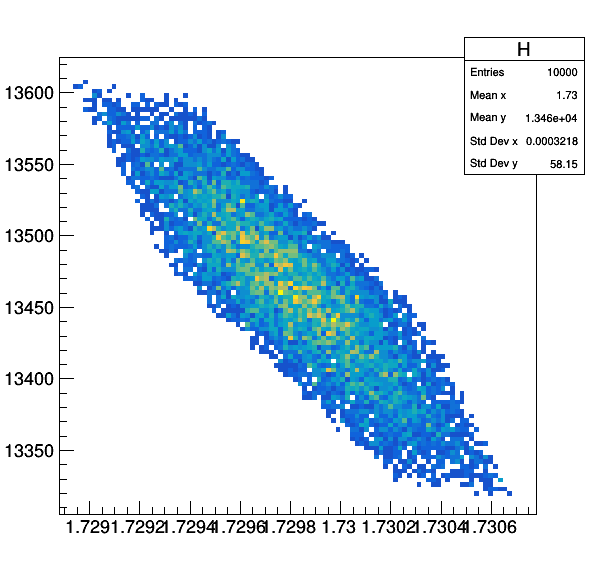

In [12]:
c3.Draw()
c3.cd()
H.Draw("COL")
print(H.GetCorrelationFactor())

Warning in <TROOT::Append>: Replacing existing TH1: H (Potential memory leak).


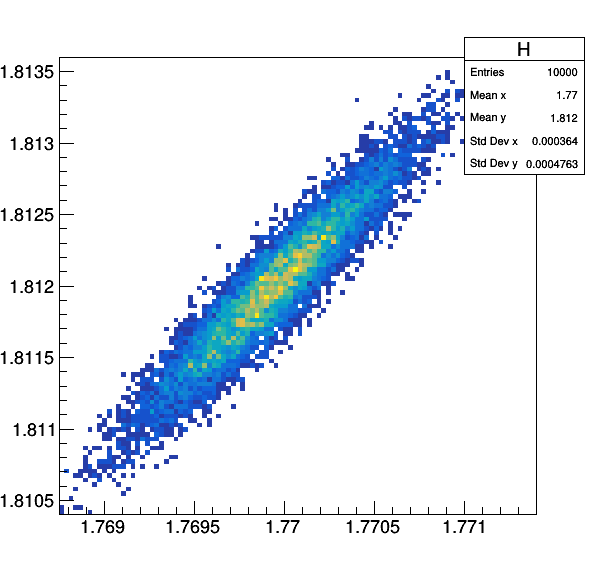

In [13]:
H=TH2D("H","",100,0,0,100,0,0)

for i in range(0,N):
    a=rnd.Gaus(meanA,sigA)
    b=rnd.Gaus(meanB,sigB)
    
    n1,n2=computeN1N2(a,b)
    
    H.Fill(n1,n2)
    
can1=TCanvas("can1","",600,600)

can1.Draw()
can1.cd()
H.Draw("COL")


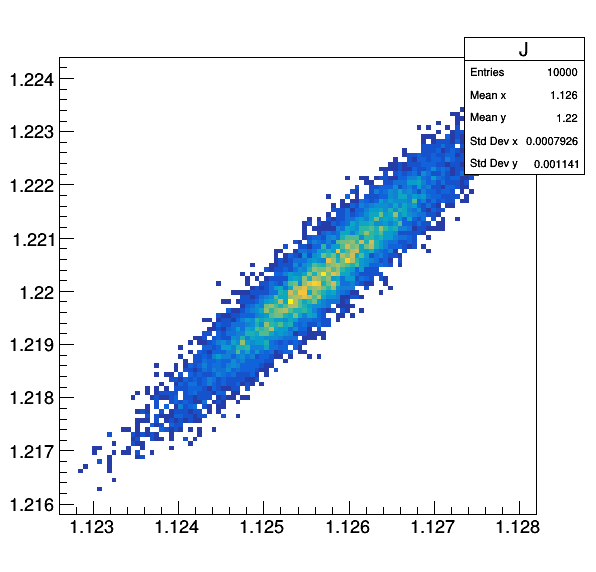

In [14]:
J=TH2D("J","",100,0,0,100,0,0)

for i in range(0,N):
    a=rnd.Gaus(meanA,sigA)
    b=rnd.Gaus(meanB,sigB)
    
    DT1,DT2=computeDT1DT2(a,b)
    
    J.Fill(DT1,DT2)
    
can2=TCanvas("can2","",600,600)
can2.Draw()
can2.cd()
J.Draw("COL")